# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [4]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [5]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [6]:
# Load and filter data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
#df_initial.drop(columns=[f"SRR277237{i:02d}_sorted.bam" for i in range(28, 40)], inplace=True)
metadata = pd.read_csv(metaPath)
#metadata = metadata[metadata['cell_state'] == 'exponential']

In [7]:
df_initial

,Chr,Start,End,Strand,Length,SRR25662251_sorted.bam,SRR25662245_sorted.bam,SRR25662240_sorted.bam,SRR25662252_sorted.bam,SRR25662264_sorted.bam,...,SRR25662248_sorted.bam,SRR25662253_sorted.bam,SRR25662246_sorted.bam,SRR25662244_sorted.bam,SRR25662250_sorted.bam,SRR25662263_sorted.bam,SRR25662242_sorted.bam,SRR25662243_sorted.bam,SRR25662239_sorted.bam,SRR25662255_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-CCNA_R0094,CP001340.1,1,182,-,182,391,152,263,455,269,...,366,495,366,306,328,289,271,319,354,805
gene-CCNA_00001,CP001340.1,202,1107,+,906,1105,448,801,1117,906,...,1164,1315,1027,1035,1015,1028,1007,948,1300,2194
gene-CCNA_00002,CP001340.1,1104,1703,+,600,765,415,593,725,704,...,863,878,749,832,830,718,806,757,952,1451
gene-CCNA_00003,CP001340.1,1700,2557,+,858,383,207,395,506,380,...,498,528,508,453,517,482,492,425,587,951
gene-CCNA_00004,CP001340.1,2559,3158,+,600,310,168,279,350,329,...,364,313,379,290,335,402,348,345,358,714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CbK_gp334,JX100813.1,212903,213493,+,591,2203,1080,1385,2116,1702,...,2365,2440,1975,1754,1850,1745,1803,1862,1346,0
gene-CbK_gp335,JX100813.1,213498,214076,+,579,2908,1350,1803,3147,2259,...,3259,3348,2386,2580,3129,2440,2910,2681,2808,0
gene-CbK_gp336,JX100813.1,214345,214791,+,447,4377,1540,3354,4704,2696,...,3571,5231,4401,3013,4014,3656,3835,2570,2052,0


In [8]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 20)
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,treatment,cell_line,tissue
0,SRR25662239,RNA-Seq,100,1330042052,PRJNA1006311,SAMN37017703,444204702,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388038,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714547,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:15:00Z,1,GSM7714547,bacterial cell,SRP455535,"CB15 infected with fCbK at 10 MOI\, 75' post-i...",NaN,NaN
1,SRR25662240,RNA-Seq,100,926250507,PRJNA1006311,SAMN37017704,311266411,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388037,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714546,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:14:00Z,1,GSM7714546,bacterial cell,SRP455535,"CB15 infected with fCbK at 10 MOI\, 75' post-i...",NaN,NaN
2,SRR25662241,RNA-Seq,100,1089541508,PRJNA1006311,SAMN37017705,365292817,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388036,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714545,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:15:00Z,1,GSM7714545,bacterial cell,SRP455535,"CB15 infected with fCbK at 10 MOI\, 75' post-i...",NaN,NaN
3,SRR25662242,RNA-Seq,100,1143963381,PRJNA1006311,SAMN37017706,390573174,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388035,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714544,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:16:00Z,1,GSM7714544,bacterial cell,SRP455535,"CB15 infected with fCbK at 10 MOI\, 60' post-i...",NaN,NaN
4,SRR25662243,RNA-Seq,100,1050133113,PRJNA1006311,SAMN37017707,360366851,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388034,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714543,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:15:00Z,1,GSM7714543,bacterial cell,SRP455535,"CB15 infected with fCbK at 10 MOI\, 60' post-i...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,SRR25662255,RNA-Seq,100,1405827466,PRJNA1006311,SAMN37017719,479707921,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388022,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714531,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:16:00Z,1,GSM7714531,bacterial cell,SRP455535,Pre-infected CB15,NaN,NaN
17,SRR25662256,RNA-Seq,100,1121959592,PRJNA1006311,SAMN37017720,385045559,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388021,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714530,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:14:00Z,1,GSM7714530,bacterial cel

## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [9]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM7714530': '0_R1',  'GSM7714531': '0_R2',  'GSM7714532': '0_R3',
              'GSM7714533': '15_R1', 'GSM7714534': '15_R2', 'GSM7714535': '15_R3',
              'GSM7714536': '30_R1', 'GSM7714537': '30_R2', 'GSM7714538': '30_R3',
              'GSM7714539': '45_R1', 'GSM7714540': '45_R2', 'GSM7714541': '45_R3',
              'GSM7714542': '60_R1', 'GSM7714543': '60_R2', 'GSM7714544': '60_R3',
              'GSM7714545': '75_R1', 'GSM7714546': '75_R2', 'GSM7714547': '75_R3',
              'GSM7714548': '90_R1', 'GSM7714549': '90_R2', 'GSM7714550': '90_R3',
}

In [10]:
metadataFull = annotateData(metadata, sampleDict)

In [11]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,treatment,cell_line,tissue
0,SRR25662239,RNA-Seq,100,1330042052,PRJNA1006311,SAMN37017703,444204702,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388038,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714547,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:15:00Z,1,GSM7714547,bacterial cell,SRP455535,"CB15 infected with fCbK at 10 MOI\, 75' post-i...",NaN,NaN


In [12]:
metadataFull.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,treatment,cell_line,tissue,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR25662239_sorted.bam,SRR25662239,RNA-Seq,100,1330042052,PRJNA1006311,SAMN37017703,444204702,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388038,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714547,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:15:00Z,1,GSM7714547,bacterial cell,SRP455535,"CB15 infected with fCbK at 10 MOI\, 75' post-i...",NaN,NaN,SRR25662239_sorted.bam,75_R3
SRR25662240_sorted.bam,SRR25662240,RNA-Seq,100,926250507,PRJNA1006311,SAMN37017704,311266411,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388037,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714546,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:14:00Z,1,GSM7714546,bacterial cell,SRP455535,"CB15 infected with fCbK at 10 MOI\, 75' post-i...",NaN,NaN,SRR25662240_sorted.bam,75_R2
SRR25662241_sorted.bam,SRR25662241,RNA-Seq,100,1089541508,PRJNA1006311,SAMN37017705,365292817,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388036,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714545,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:15:00Z,1,GSM7714545,bacterial cell,SRP455535,"CB15 infected with fCbK at 10 MOI\, 75' post-i...",NaN,NaN,SRR25662241_sorted.bam,75_R1
SRR25662242_sorted.bam,SRR25662242,RNA-Seq,100,1143963381,PRJNA1006311,SAMN37017706,390573174,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388035,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714544,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:16:00Z,1,GSM7714544,bacterial cell,SRP455535,"CB15 infected with fCbK at 10 MOI\, 60' post-i...",NaN,NaN,SRR25662242_sorted.bam,60_R3
SRR25662243_sorted.bam,SRR25662243,RNA-Seq,100,1050133113,PRJNA1006311,SAMN37017707,360366851,bacterial cell,"DEPT. MICROBIOLOGY AND MOLECULAR GENETICS, MIC...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX21388034,CB15,uncalculated,uncalculated,missing,NextSeq 2000,GSM7714543,PAIRED,cDNA,TRANSCRIPTOMIC,Caulobacter vibrioides CB15,ILLUMINA,2023-08-25T00:00:00Z,2023-08-17T10:15:00Z,1,GSM7714543,bacterial cell,SRP455535,"CB15 infected with fCbK at 10 MOI\, 60' post-i...",NaN,NaN,SRR25662243_sorted.bam,60_R2


Add correct sample names.

In [13]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_R1', '0_R2', '0_R3', '15_R1', '15_R2', '15_R3', '30_R1', '30_R2', '30_R3', '45_R1', '45_R2', '45_R3',
         '60_R1', '60_R2', '60_R3', '75_R1', '75_R2', '75_R3', '90_R1', '90_R2', '90_R3']]
df.head()

SampleNames,0_R1,0_R2,0_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,60_R1,60_R2,60_R3,75_R1,75_R2,75_R3,90_R1,90_R2,90_R3
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-CCNA_R0094,801,805,876,495,455,391,328,382,366,332,366,152,306,319,271,341,263,354,296,269,289
gene-CCNA_00001,1710,2194,1719,1315,1117,1105,1015,1123,1164,1146,1027,448,1035,948,1007,1048,801,1300,1010,906,1028
gene-CCNA_00002,1222,1451,1123,878,725,765,830,944,863,813,749,415,832,757,806,655,593,952,799,704,718
gene-CCNA_00003,823,951,622,528,506,383,517,494,498,470,508,207,453,425,492,461,395,587,435,380,482
gene-CCNA_00004,464,714,515,313,350,310,335,366,364,349,379,168,290,345,348,328,279,358,319,329,402


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [14]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [15]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/JX100813.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "JX100813.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
4097,JX100813.1,Genbank,gene,1002.0,1193.0,.,+,.,gene-CbK_gp001,CbK_gp001,Gene,protein_coding,CbK_gp001,gene-CbK_gp001,hypothetical protein,hypothetical protein,7368,unknown function
4098,JX100813.1,Genbank,gene,1277.0,1540.0,.,+,.,gene-CbK_gp002,CbK_gp002,Gene,protein_coding,CbK_gp002,gene-CbK_gp002,hypothetical protein,hypothetical protein,16102,unknown function
4099,JX100813.1,Genbank,gene,1586.0,1690.0,.,+,.,gene-CbK_gp003,CbK_gp003,Gene,protein_coding,CbK_gp003,gene-CbK_gp003,hypothetical protein,hypothetical protein,11446,unknown function
4100,JX100813.1,Genbank,gene,2384.0,2569.0,.,+,.,gene-CbK_gp004,CbK_gp004,Gene,protein_coding,CbK_gp004,gene-CbK_gp004,hypothetical protein,hypothetical protein,7291,unknown function
4101,JX100813.1,Genbank,gene,2669.0,3472.0,.,+,.,gene-CbK_gp005,CbK_gp005,Gene,protein_coding,CbK_gp005,gene-CbK_gp005,hypothetical protein,hypothetical protein,8188,unknown function
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,JX100813.1,Genbank,gene,212903.0,213493.0,.,+,.,gene-CbK_gp334,CbK_gp334,Gene,protein_coding,CbK_gp334,gene-CbK_gp334,hypothetical protein,hypothetical protein,7318,unknown function
4431,JX100813.1,Genbank,gene,213498.0,214076.0,.,+,.,gene-CbK_gp335,CbK_gp335,Gene,protein_coding,CbK_gp335,gene-CbK_gp335,hypothetical protein,hypothetical protein,8002,unknown function
4432,JX100813.1,Genbank,gene,214345.0,214791.0,.,+,.,gene-CbK_gp336,CbK_gp336,Gene,protein_coding,CbK_gp336,gene-CbK_gp336,hypothetical protein,hypothetical protein,6738,unknown function
4433,JX100813.1,Genbank,gene,214934.0,215326.0,.,+,.,gene-CbK_gp337,CbK_gp337,Gene,protein_coding,CbK_gp337,gene-CbK_gp337,hypothetical protein,hypothetical protein,7192,unknown function


In [16]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'CP001340.1', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

In [17]:
gff3

,0,1,2,3,4,5,6,7,8,ID,GeneType,Symbol,Entity
ID,,,,,,,,,,,,,
gene-CCNA_R0094,CP001340.1,Genbank,gene,1.0,182.0,.,-,.,ID=gene-CCNA_R0094;Name=ccnA;gbkey=Gene;gene=c...,gene-CCNA_R0094,ncRNA,ccnA,host
gene-CCNA_00001,CP001340.1,Genbank,gene,202.0,1107.0,.,+,.,ID=gene-CCNA_00001;Name=CCNA_00001;gbkey=Gene;...,gene-CCNA_00001,protein_coding,None,host
gene-CCNA_00002,CP001340.1,Genbank,gene,1104.0,1703.0,.,+,.,ID=gene-CCNA_00002;Name=CCNA_00002;gbkey=Gene;...,gene-CCNA_00002,protein_coding,None,host
gene-CCNA_00003,CP001340.1,Genbank,gene,1700.0,2557.0,.,+,.,ID=gene-CCNA_00003;Name=CCNA_00003;experiment=...,gene-CCNA_00003,protein_coding,None,host
gene-CCNA_00004,CP001340.1,Genbank,gene,2559.0,3158.0,.,+,.,ID=gene-CCNA_00004;Name=CCNA_00004;experiment=...,gene-CCNA_00004,protein_coding,None,host
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CbK_gp334,JX100813.1,Genbank,gene,212903.0,213493.0,.,+,.,ID=gene-CbK_gp334;Name=CbK_gp334;gbkey=Gene;ge...,gene-CbK_gp334,protein_coding,None,phage
gene-CbK_gp335,JX100813.1,Genbank,gene,213498.0,214076.0,.,+,.,ID=gene-CbK_gp335;Name=CbK_gp335;gbkey=Gene;ge...,gene-CbK_gp335,protein_coding,None,phage
gene-CbK_gp336,JX100813.1,Genbank,gene,214345.0,214791.0,.,+,.,ID=gene-CbK_gp336;Name=CbK_gp336;gbkey=Gene;ge...,gene-CbK_gp336,protein_coding,None,phage


Perform in silico rRNA depletion.

In [18]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs.head()

SampleNames,0_R1,0_R2,0_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,60_R1,60_R2,60_R3,75_R1,75_R2,75_R3,90_R1,90_R2,90_R3
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-CCNA_00166,1296,1334,1160,1382,1124,1137,832,946,946,1154,1173,303,797,894,884,1126,1054,1047,953,933,1165
gene-CCNA_01204,1042,1460,1094,941,796,813,839,973,898,934,944,445,813,858,973,878,811,1065,914,879,1000
gene-CCNA_02892,93,11,71,71,68,71,49,67,76,78,46,25,60,69,47,57,44,63,66,49,51
gene-CbK_gp128,0,0,0,8208,8022,7019,19956,22704,21919,30960,28973,18108,24464,31851,25066,29219,24227,28219,27333,24346,25506
gene-CCNA_01330,74176,85131,78649,59682,56527,54502,50613,58516,60215,38156,39996,26464,37659,39012,43872,31866,28390,46242,35405,30754,32874


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [19]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [20]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,60_R1,60_R2,60_R3,75_R1,75_R2,75_R3,90_R1,90_R2,90_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,
gene-CCNA_00166,79.389515,70.431419,71.064703,75.147343,66.864854,72.390643,55.280038,59.639470,57.014881,74.361469,72.371874,41.094175,56.908003,62.298837,56.682377,74.820471,81.643622,59.333653,66.531369,71.131050,83.037264,host,hvyA
gene-CCNA_01204,55.149586,66.592448,57.902876,44.212429,40.916623,44.726422,48.159321,52.993753,46.758573,52.000665,50.322736,52.112853,50.150559,51.655368,53.896646,50.408825,54.279991,52.140606,55.127086,57.897032,61.581946,host,gene-CCNA_01204
gene-CCNA_02892,15.788094,1.673683,12.073753,10.717216,11.231984,12.547712,9.063934,11.728552,12.707394,13.942837,7.908009,9.521146,11.904893,13.347866,8.394045,10.531362,9.500865,9.918551,12.795429,10.401059,10.118018,host,gene-CCNA_02892
gene-CbK_gp128,0.043761,0.037718,0.043763,637.736939,681.832106,638.508215,1894.077501,2044.816684,1887.241726,2850.304587,2553.976891,3504.558642,2495.216760,3170.726354,2296.006952,2773.903200,2681.103388,2284.681418,2726.027857,2651.616489,2597.412362,phage,gene-CbK_gp128
gene-CCNA_01330,3657.799661,3618.271005,3878.535027,2612.512915,2706.831174,2793.253832,2706.533510,2969.302533,2921.049070,1979.180968,1986.422657,2885.680311,2164.114094,2188.095754,2264.151860,1704.458991,1770.156521,2109.362929,1989.479391,1887.193856,1886.178801,host,rpoA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CCNA_03141,15.599112,11.350666,13.267089,9.878436,11.655733,9.444454,13.543204,8.950976,10.660478,13.034621,10.914298,11.067843,14.327400,12.325617,11.442922,11.543501,12.473144,11.822437,11.241027,10.219645,12.947933,host,gene-CCNA_03141
gene-CCNA_03104,77.703855,55.943529,56.032930,48.057481,50.646353,42.169989,59.147667,38.692629,44.303613,57.562584,50.214238,41.497823,56.105562,43.587569,52.980010,49.093944,50.107214,41.784978,46.749229,42.921889,49.359394,host,gene-CCNA_03104
gene-CCNA_03468,75.882554,55.259642,62.187440,33.239361,38.397492,29.474371,38.605084,28.118451,30.703494,33.947627,31.321908,28.217843,32.885954,28.536159,31.435336,30.791485,30.803817,30.474606,31.201227,30.142198,26.752115,host,gene-CCNA_03468


In [21]:
# Check gene names unique
len(tpms['Symbol'].unique())

4429

Log2+1 normalization raw counts

In [22]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,0_R1,0_R2,0_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,60_R1,60_R2,60_R3,75_R1,75_R2,75_R3,90_R1,90_R2,90_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,
gene-CCNA_00166,10.340963,10.382624,10.181152,10.433585,10.135709,10.152285,9.702173,9.887221,9.887221,10.173677,10.197217,8.247928,9.640245,9.805744,9.789534,10.138272,10.043027,10.033423,9.897845,9.867279,10.187352,host,hvyA
gene-CCNA_01204,10.026523,10.512740,10.096715,9.879583,9.638436,9.668885,9.714246,9.927778,9.812177,9.868823,9.884171,8.800900,9.668885,9.746514,9.927778,9.779719,9.665336,10.057992,9.837628,9.781360,9.967226,host,gene-CCNA_01204
gene-CCNA_02892,6.554589,3.584963,6.169925,6.169925,6.108524,6.169925,5.643856,6.087463,6.266787,6.303781,5.554589,4.700440,5.930737,6.129283,5.584963,5.857981,5.491853,6.000000,6.066089,5.643856,5.700440,host,gene-CCNA_02892
gene-CbK_gp128,0.000000,0.000000,0.000000,13.002991,12.969926,12.777255,14.284607,14.470722,14.419960,14.918164,14.822471,14.144419,14.578432,14.959096,14.613502,14.834669,14.564388,14.784430,14.738409,14.571456,14.638606,phage,gene-CbK_gp128
gene-CCNA_01330,16.178684,16.377414,16.263159,15.865032,15.786678,15.734048,15.627249,15.836568,15.877859,15.219660,15.287604,14.691798,15.200745,15.251667,15.421046,14.959776,14.793146,15.496947,15.111706,14.908533,15.004703,host,rpoA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CCNA_03141,7.330917,7.087463,7.098032,6.845490,6.954196,6.554589,7.011227,6.491853,6.807355,7.000000,6.807355,5.700440,6.988685,6.807355,6.820179,6.781360,6.672425,7.044394,6.672425,6.409391,6.845490,host,gene-CCNA_03141
gene-CCNA_03104,10.752381,10.492855,10.280771,10.231221,10.177420,9.815383,10.241983,9.705632,9.965784,10.246741,10.112440,8.703904,10.062046,9.733015,10.134426,9.972980,9.781360,9.970106,9.831307,9.581201,9.879583,host,gene-CCNA_03104
gene-CCNA_03468,11.406736,11.163650,11.119590,10.388017,10.466586,9.987264,10.315150,9.933691,10.125413,10.173677,10.120238,8.836050,9.980140,9.810572,10.070121,9.988685,9.768184,10.203348,9.936638,9.759888,9.684749,host,gene-CCNA_03468


Log2+1 normalization tpms

In [23]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,0_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,60_R1,60_R2,60_R3,75_R1,75_R2,75_R3,90_R1,90_R2,90_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,
gene-CCNA_00166,6.328935,6.158487,6.171221,6.250722,6.084593,6.197524,5.814551,5.922185,5.858351,6.235755,6.197155,5.395549,5.855691,5.984107,5.850059,6.244516,6.368832,5.914891,6.077486,6.172549,6.392957,host,hvyA
gene-CCNA_01204,5.811203,6.078790,5.880266,5.498648,5.389451,5.514956,5.619393,5.754721,5.577688,5.727939,5.681526,5.730989,5.676678,5.718509,5.778646,5.683944,5.788685,5.731743,5.810625,5.880123,5.967675,host,gene-CCNA_01204
gene-CCNA_02892,4.069367,1.418828,3.708601,3.550558,3.612586,3.759977,3.331122,3.669996,3.776882,3.901382,3.155103,3.395220,3.689846,3.842764,3.231746,3.527491,3.392436,3.448710,3.786118,3.511096,3.474828,host,gene-CCNA_02892
gene-CbK_gp128,0.061792,0.053414,0.061794,9.319078,9.415387,9.320819,10.888041,10.998461,10.882828,11.477406,11.319095,11.775429,11.285528,11.631053,11.165540,11.438222,11.389149,11.158409,11.413114,11.373200,11.343415,phage,gene-CbK_gp128
gene-CCNA_01330,11.837155,11.821483,11.921668,11.351775,11.402922,11.448247,11.402763,11.536394,11.512765,10.951417,10.956683,11.495196,11.080227,11.096119,11.145392,10.735944,10.790476,11.043275,10.958900,10.882791,10.882015,host,rpoA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CCNA_03141,4.053034,3.626517,3.834619,3.443399,3.661719,3.384665,3.862273,3.314838,3.543555,3.810918,3.574622,3.593096,3.938041,3.736130,3.637253,3.648868,3.752015,3.680599,3.613653,3.487955,3.801979,host,gene-CCNA_03141
gene-CCNA_03104,6.298362,5.831460,5.833723,5.616401,5.690595,5.431957,5.910437,5.310799,5.501554,5.871907,5.678473,5.409317,5.835559,5.478570,5.754353,5.646564,5.675455,5.419032,5.577406,5.456868,5.654189,host,gene-CCNA_03104
gene-CCNA_03468,6.264584,5.814028,5.981566,5.097584,5.300032,4.929525,5.307614,4.863862,4.986570,5.127123,5.014440,4.868778,5.082615,4.884410,5.019494,4.990568,4.991128,4.976116,5.009044,4.960799,4.794526,host,gene-CCNA_03468


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [24]:
columnOrder = ['0_R1', '0_R2', '0_R3', '15_R1', '15_R2', '15_R3',
               '30_R1', '30_R2', '30_R3', '45_R1', '45_R2', '45_R3',
               '60_R1', '60_R2', '60_R3', '75_R1', '75_R2', '75_R3',
               '90_R1', '90_R2', '90_R3']

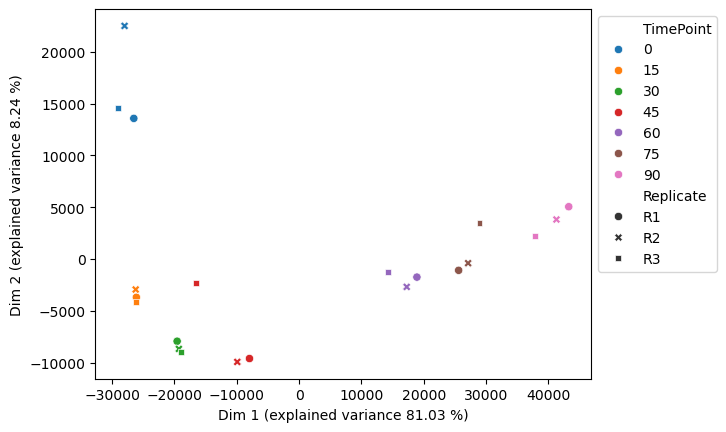

In [25]:
txPCA(tpms[columnOrder])

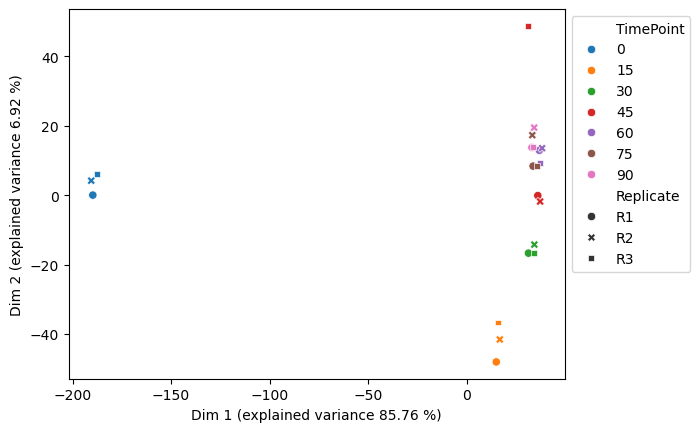

In [26]:
txPCA(logs[columnOrder])

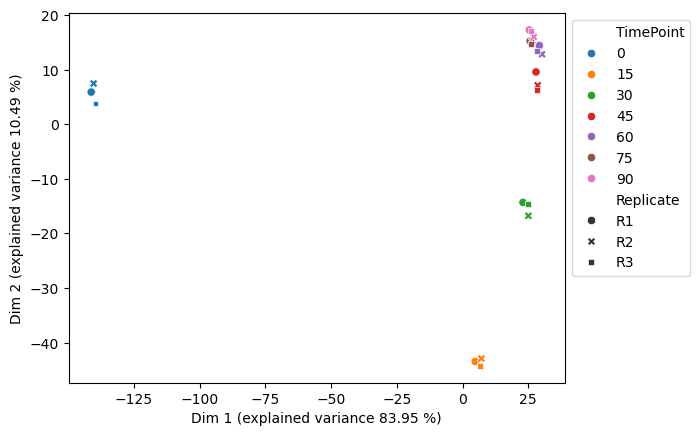

In [27]:
txPCA(logTPMs[columnOrder])

In [28]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

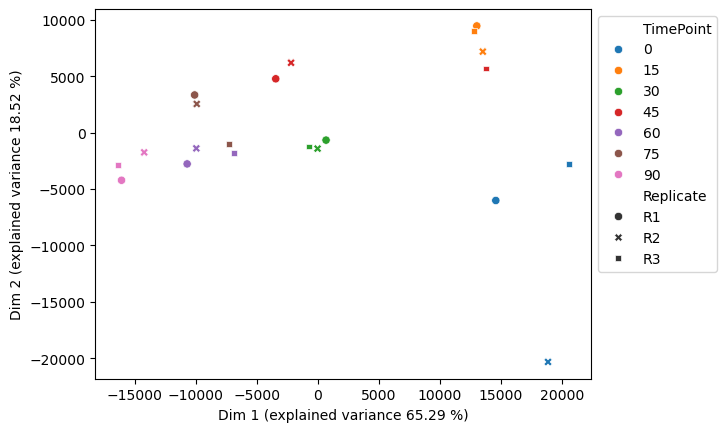

In [29]:
txPCA(tpmHost[columnOrder])

tpmPhage

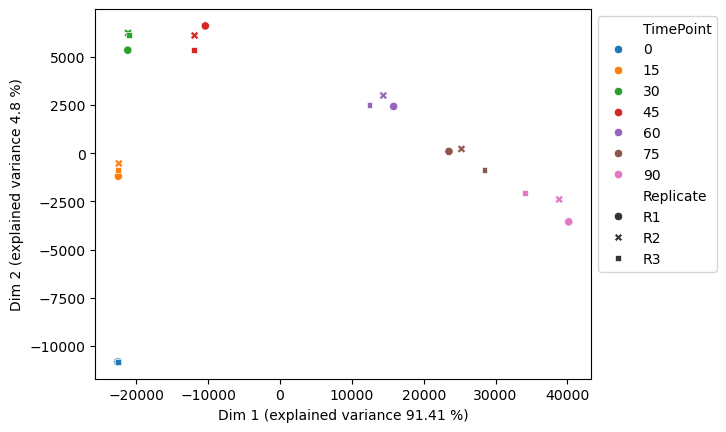

In [30]:
txPCA(tpmPhage[columnOrder])

logTPM Host

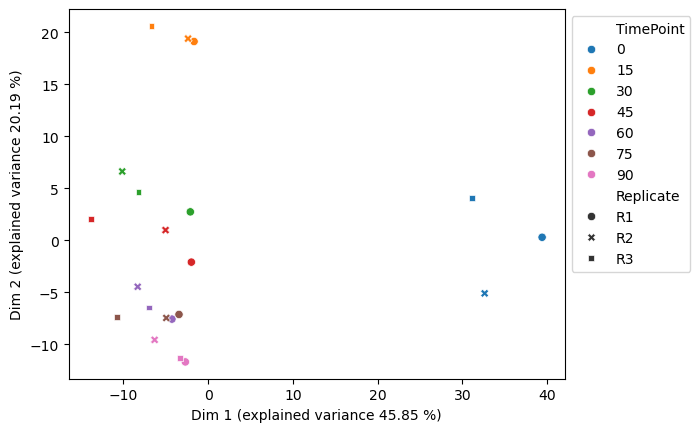

In [31]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

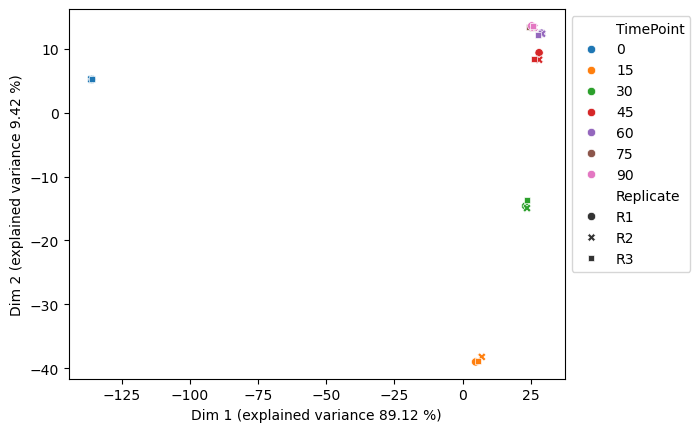

In [32]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Looks great.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [33]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['0', '15', '30', '45', '60', '75', '90']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,15,30,45,60,75,90,Entity,Symbol
Geneid,,,,,,,,,
gene-CCNA_00166,73.628546,71.467614,57.311463,62.609173,58.629739,71.932582,73.566561,host,hvyA
gene-CCNA_01204,59.881637,43.285158,49.303882,51.478751,51.900858,52.276474,58.202022,host,gene-CCNA_01204
gene-CCNA_02892,9.845177,11.498970,11.166627,10.457330,11.215601,9.983593,11.104835,host,gene-CCNA_02892
gene-CbK_gp128,0.041747,652.692420,1942.045304,2969.613374,2653.983355,2579.896002,2658.352236,phage,gene-CbK_gp128
gene-CCNA_01330,3718.201898,2704.199307,2865.628371,2283.761312,2205.453902,1861.326147,1920.950683,host,rpoA
...,...,...,...,...,...,...,...,...,...
gene-CCNA_03141,13.405622,10.326208,11.051553,11.672254,12.698646,11.946361,11.469535,host,gene-CCNA_03141
gene-CCNA_03104,63.226771,46.957941,47.381303,49.758215,50.891047,46.995379,46.343504,host,gene-CCNA_03104
gene-CCNA_03468,64.443212,33.703741,32.475676,31.162459,30.952483,30.689969,29.365180,host,gene-CCNA_03468


In [34]:
TPMsds = TPMsds[['0', '15', '30', '45', '60', '75', '90']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,15,30,45,60,75,90,Entity,Symbol
Geneid,,,,,,,,,
gene-CCNA_00166,4.081817,3.443728,1.792044,15.235068,2.596078,9.334117,6.955091,host,hvyA
gene-CCNA_01204,4.876570,1.687901,2.671065,0.818708,1.539154,1.583315,2.643996,host,gene-CCNA_01204
gene-CCNA_02892,5.973780,0.770774,1.539593,2.551094,2.080293,0.423205,1.201002,host,gene-CCNA_02892
gene-CbK_gp128,0.002849,20.607276,72.723904,397.137555,374.333748,212.158257,52.722633,phage,gene-CbK_gp128
gene-CCNA_01330,114.515393,73.810635,114.208816,425.631273,42.644794,177.427403,48.458886,host,rpoA
...,...,...,...,...,...,...,...,...,...
gene-CCNA_03141,1.737185,0.956666,1.895054,0.965376,1.206763,0.389509,1.125478,host,gene-CCNA_03141
gene-CCNA_03104,10.236909,3.546729,8.629650,6.566333,5.319641,3.707460,2.643713,host,gene-CCNA_03104
gene-CCNA_03468,8.569034,3.657618,4.460780,2.341890,1.808321,0.152368,1.897624,host,gene-CCNA_03468


In [35]:
propExp = proportionalExp(TPMmeans[['0', '15', '30', '45', '60', '75', '90']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,15,30,45,60,75,90,Entity,Symbol
Geneid,,,,,,,,,
gene-CCNA_00166,1.000000,0.970651,0.778386,0.850338,0.796291,0.976966,0.999158,host,hvyA
gene-CCNA_01204,1.000000,0.722845,0.823356,0.859675,0.866724,0.872997,0.971951,host,gene-CCNA_01204
gene-CCNA_02892,0.856179,1.000000,0.971098,0.909414,0.975357,0.868216,0.965724,host,gene-CCNA_02892
gene-CbK_gp128,0.000014,0.219790,0.653972,1.000000,0.893713,0.868765,0.895185,phage,gene-CbK_gp128
gene-CCNA_01330,1.000000,0.727287,0.770703,0.614211,0.593151,0.500598,0.516634,host,rpoA
...,...,...,...,...,...,...,...,...,...
gene-CCNA_03141,1.000000,0.770289,0.824397,0.870698,0.947263,0.891146,0.855576,host,gene-CCNA_03141
gene-CCNA_03104,1.000000,0.742691,0.749387,0.786980,0.804897,0.743283,0.732973,host,gene-CCNA_03104
gene-CCNA_03468,1.000000,0.522999,0.503943,0.483565,0.480306,0.476233,0.455675,host,gene-CCNA_03468


## 5. Phage gene classification

In [36]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('middle')
        elif timePoint == 5:
            labels.append('late')
        elif timePoint == 6:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [37]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('middle')
        elif timePoint == 5:
            labels.append('late')
        elif timePoint == 6:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [38]:
TPMmeans

,0,15,30,45,60,75,90,Entity,Symbol
Geneid,,,,,,,,,
gene-CCNA_00166,73.628546,71.467614,57.311463,62.609173,58.629739,71.932582,73.566561,host,hvyA
gene-CCNA_01204,59.881637,43.285158,49.303882,51.478751,51.900858,52.276474,58.202022,host,gene-CCNA_01204
gene-CCNA_02892,9.845177,11.498970,11.166627,10.457330,11.215601,9.983593,11.104835,host,gene-CCNA_02892
gene-CbK_gp128,0.041747,652.692420,1942.045304,2969.613374,2653.983355,2579.896002,2658.352236,phage,gene-CbK_gp128
gene-CCNA_01330,3718.201898,2704.199307,2865.628371,2283.761312,2205.453902,1861.326147,1920.950683,host,rpoA
...,...,...,...,...,...,...,...,...,...
gene-CCNA_03141,13.405622,10.326208,11.051553,11.672254,12.698646,11.946361,11.469535,host,gene-CCNA_03141
gene-CCNA_03104,63.226771,46.957941,47.381303,49.758215,50.891047,46.995379,46.343504,host,gene-CCNA_03104
gene-CCNA_03468,64.443212,33.703741,32.475676,31.162459,30.952483,30.689969,29.365180,host,gene-CCNA_03468


In [39]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [40]:
pd.set_option('display.max_rows', 20)
TPMmeans[TPMmeans['Entity'] == 'phage'].sort_index()

,0,15,30,45,60,75,90,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,,,,
gene-CbK_gp001,0.124590,1.570073,10.982320,639.545012,639.460983,429.257181,407.609191,phage,gene-CbK_gp001,middle,middle
gene-CbK_gp002,0.090611,1.362387,1.984816,479.360595,446.265294,309.394195,297.142957,phage,gene-CbK_gp002,middle,middle
gene-CbK_gp003,0.227822,0.372021,1.061692,191.064123,181.895726,133.889633,120.147117,phage,gene-CbK_gp003,middle,middle
gene-CbK_gp004,0.128609,311.476327,391.057853,489.106494,447.810088,373.187956,485.167404,phage,gene-CbK_gp004,early,middle
gene-CbK_gp005,0.029753,159.359013,181.311680,167.852610,181.212640,146.616982,183.081494,phage,gene-CbK_gp005,early,late
...,...,...,...,...,...,...,...,...,...,...,...
gene-CbK_gp334,0.040476,184.188690,183.399767,170.823493,171.140031,135.114447,170.761880,phage,gene-CbK_gp334,early,early
gene-CbK_gp335,0.041315,261.337372,288.050344,222.472633,262.821803,204.934775,244.275347,phage,gene-CbK_gp335,early,middle
gene-CbK_gp336,0.053515,514.661194,390.272119,433.826882,390.785943,386.385527,384.885656,phage,gene-CbK_gp336,early,early


In [41]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
middle    156
early     132
late       50
Name: count, dtype: int64

Add classes to other dfs.

In [42]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'CP001340.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'JX100813.1']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [43]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [44]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,60_R1,60_R2,60_R3,75_R1,75_R2,75_R3,90_R1,90_R2,90_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-CCNA_00166,79.389515,70.431419,71.064703,75.147343,66.864854,72.390643,55.280038,59.639470,57.014881,74.361469,72.371874,41.094175,56.908003,62.298837,56.682377,74.820471,81.643622,59.333653,66.531369,71.131050,83.037264,host,hvyA,None,None,1.536048
gene-CCNA_01204,55.149586,66.592448,57.902876,44.212429,40.916623,44.726422,48.159321,52.993753,46.758573,52.000665,50.322736,52.112853,50.150559,51.655368,53.896646,50.408825,54.279991,52.140606,55.127086,57.897032,61.581946,host,gene-CCNA_01204,None,None,0.626998
gene-CCNA_02892,15.788094,1.673683,12.073753,10.717216,11.231984,12.547712,9.063934,11.728552,12.707394,13.942837,7.908009,9.521146,11.904893,13.347866,8.394045,10.531362,9.500865,9.918551,12.795429,10.401059,10.118018,host,gene-CCNA_02892,None,None,0.713100
gene-CbK_gp128,0.043761,0.037718,0.043763,637.736939,681.832106,638.508215,1894.077501,2044.816684,1887.241726,2850.304587,2553.976891,3504.558642,2495.216760,3170.726354,2296.006952,2773.903200,2681.103388,2284.681418,2726.027857,2651.616489,2597.412362,phage,gene-CbK_gp128,early,middle,614.206744
gene-CCNA_01330,3657.799661,3618.271005,3878.535027,2612.512915,2706.831174,2793.253832,2706.533510,2969.302533,2921.049070,1979.180968,1986.422657,2885.680311,2164.114094,2188.095754,2264.151860,1704.458991,1770.156521,2109.362929,1989.479391,1887.193856,1886.178801,host,rpoA,None,None,158.547880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CCNA_03141,15.599112,11.350666,13.267089,9.878436,11.655733,9.444454,13.543204,8.950976,10.660478,13.034621,10.914298,11.067843,14.327400,12.325617,11.442922,11.543501,12.473144,11.822437,11.241027,10.219645,12.947933,host,gene-CCNA_03141,None,None,0.213098
gene-CCNA_03104,77.703855,55.943529,56.032930,48.057481,50.646353,42.169989,59.147667,38.692629,44.303613,57.562584,50.214238,41.497823,56.105562,43.587569,52.980010,49.093944,50.107214,41.784978,46.749229,42.921889,49.359394,host,gene-CCNA_03104,None,None,1.416449
gene-CCNA_03468,75.882554,55.259642,62.187440,33.239361,38.397492,29.474371,38.605084,28.118451,30.703494,33.947627,31.321908,28.217843,32.885954,28.536159,31.435336,30.791485,30.803817,30.474606,31.201227,30.142198,26.752115,host,gene-CCNA_03468,None,None,4.220060


In [45]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [46]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAs

SampleNames,0_R1,0_R2,0_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,60_R1,60_R2,60_R3,75_R1,75_R2,75_R3,90_R1,90_R2,90_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,
gene-CCNA_00166,1296,1334,1160,1382,1124,1137,832,946,946,1154,1173,303,797,894,884,1126,1054,1047,953,933,1165,host,hvyA
gene-CCNA_01204,1042,1460,1094,941,796,813,839,973,898,934,944,445,813,858,973,878,811,1065,914,879,1000,host,gene-CCNA_01204
gene-CCNA_02892,93,11,71,71,68,71,49,67,76,78,46,25,60,69,47,57,44,63,66,49,51,host,gene-CCNA_02892
gene-CbK_gp128,0,0,0,8208,8022,7019,19956,22704,21919,30960,28973,18108,24464,31851,25066,29219,24227,28219,27333,24346,25506,phage,gene-CbK_gp128
gene-CCNA_01330,74176,85131,78649,59682,56527,54502,50613,58516,60215,38156,39996,26464,37659,39012,43872,31866,28390,46242,35405,30754,32874,host,rpoA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CCNA_03141,160,135,136,114,123,93,128,89,111,127,111,51,126,111,112,109,101,131,101,84,114,host,gene-CCNA_03141
gene-CCNA_03104,1724,1440,1243,1201,1157,900,1210,834,999,1214,1106,416,1068,850,1123,1004,879,1002,910,765,941,host,gene-CCNA_03104
gene-CCNA_03468,2714,2293,2224,1339,1414,1014,1273,977,1116,1154,1112,456,1009,897,1074,1015,871,1178,979,866,822,host,gene-CCNA_03468


In [47]:
# Full TPM table
tpms.to_csv('McLaughlin_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('McLaughlin_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('McLaughlin_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('McLaughlin_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('McLaughlin_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('McLaughlin_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('McLaughlin_phage_gff3.tsv', sep='\t')